In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

# Data Generation

In [9]:
sns.set_style(
    style='darkgrid',
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

# Kaggle Data


In [10]:
prod_df = pd.read_csv('perrin-freres-monthly-champagne-.csv')


In [11]:
prod_df.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [12]:
prod_df.tail()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [13]:
prod_df = prod_df.dropna()

In [14]:
prod_df.columns = ["Date", "Sales"]

In [15]:
prod_df.head()

,Date,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [16]:
prod_df["Date"] = pd.to_datetime(prod_df["Date"])

In [17]:
prod_df.head()

,Date,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [18]:
prod_df.set_index('Date',inplace=True)

In [19]:
prod_df.head()

,Sales
Date,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


In [20]:
prod_df.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


[Text(0.5, 1.0, 'Kaggle Wine Sales'), Text(0.5, 0, 'years'), Text(0, 0.5, '')]

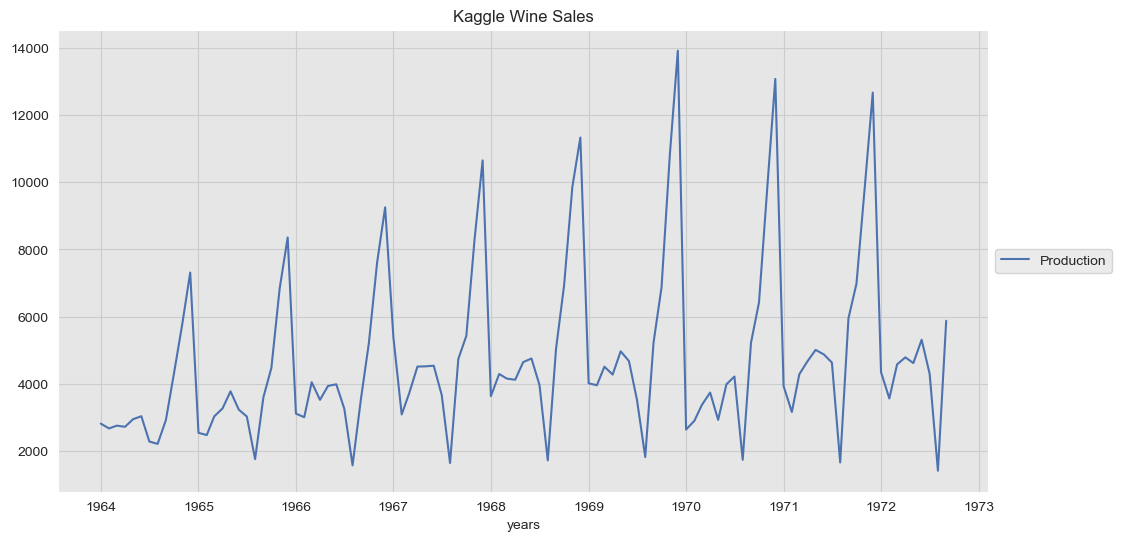

In [21]:
fig, ax = plt.subplots()
sns.lineplot(x='Date', y='Sales', data=prod_df, color=sns_c[0], label='Production', ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Kaggle Wine Sales', xlabel='years', ylabel='')

# Preprocessing

- Seasonal Decomposing

In [22]:
df = prod_df.copy() 

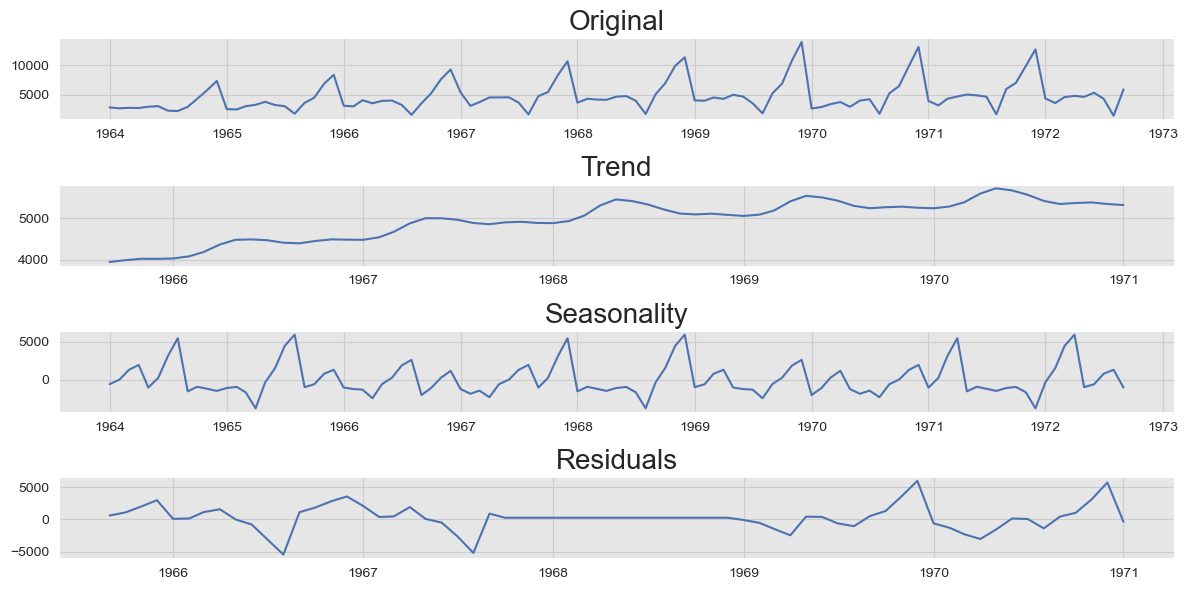

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

def seasonal_decompose_analysis(timeseries, model, periods):
    decomposition = seasonal_decompose(timeseries, model = model, period = periods)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.title('Original', fontsize=20)
    plt.plot(timeseries, label='Original')
    plt.subplot(412)
    plt.title('Trend', fontsize=20)
    plt.plot(trend, label='Trend')
    plt.subplot(413)
    plt.title('Seasonality', fontsize=20)
    plt.plot(seasonal,label='Seasonality')
    plt.subplot(414)
    plt.title('Residuals', fontsize=20)
    plt.plot(residual, label='Residuals')
    plt.tight_layout()

seasonal_decompose_analysis(df['Sales'], 'additive', 40)

We observe a seasonality of around 1 year or 12 months

- Check Stationarity

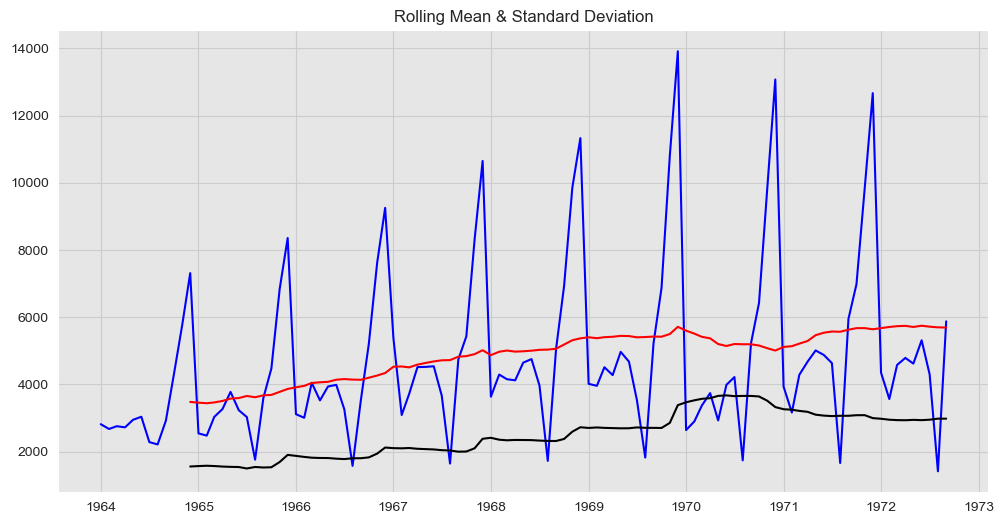

Results of Dickey-Fuller Test
Test Statistic                 -1.833593
p-value                         0.363916
#Lags Used                     11.000000
Number of Observations Used    93.000000
Critical Value (1%)            -3.502705
Critical Value (5%)            -2.893158
Critical Value (10%)           -2.583637
dtype: float64


In [24]:
from statsmodels.tsa.stattools import adfuller

def stationarity_test(timeseries, rolling_window):
    rolling_mean = timeseries.rolling(window=rolling_window).mean()
    rolling_std = timeseries.rolling(window=rolling_window).std()

    orig = plt.plot(timeseries, color='blue', label= 'Original')
    mean = plt.plot(rolling_mean, color='red', label= 'Rolling Mean')
    std = plt.plot(rolling_std, color='black', label = 'Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test')
    test = adfuller(timeseries, autolag='AIC')
    output = pd.Series(test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
        output['Critical Value (%s)'%key] = value
    print(output)
    
stationarity_test(timeseries = df['Sales'], rolling_window = 12)

- p-value is greater than 0 (usually want it to be less than 0.05) => non-stationary
- remove stationarity

- perform seasonal first difference

In [25]:
df['Seasonal First Difference'] = df['Sales'] - df['Sales'].shift(12)

- perform dickey fuller test

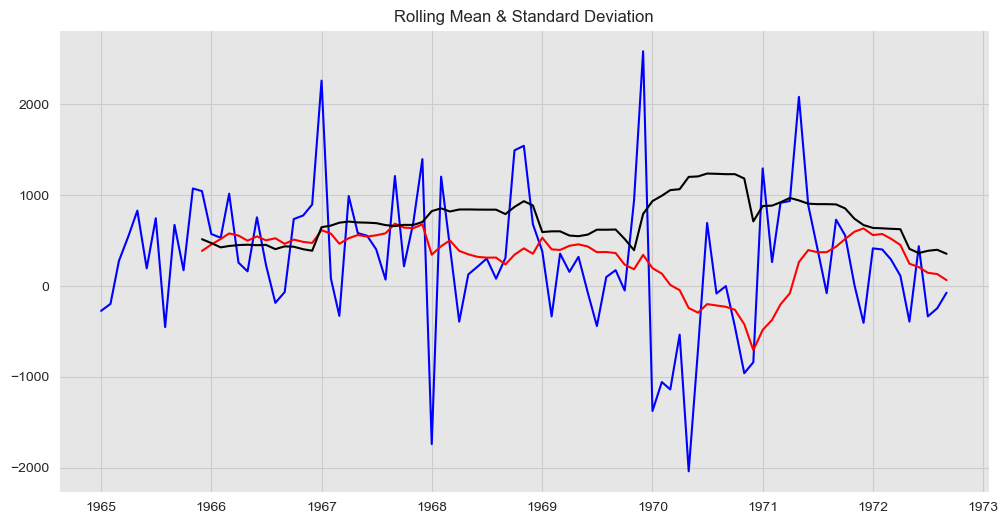

Results of Dickey-Fuller Test
Test Statistic                -7.626619e+00
p-value                        2.060580e-11
#Lags Used                     0.000000e+00
Number of Observations Used    9.200000e+01
Critical Value (1%)           -3.503515e+00
Critical Value (5%)           -2.893508e+00
Critical Value (10%)          -2.583824e+00
dtype: float64


In [26]:
stationarity_test(df['Seasonal First Difference'].dropna(),12)

- perform acf and pacf to determine parameters of SARIMAX

In [27]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


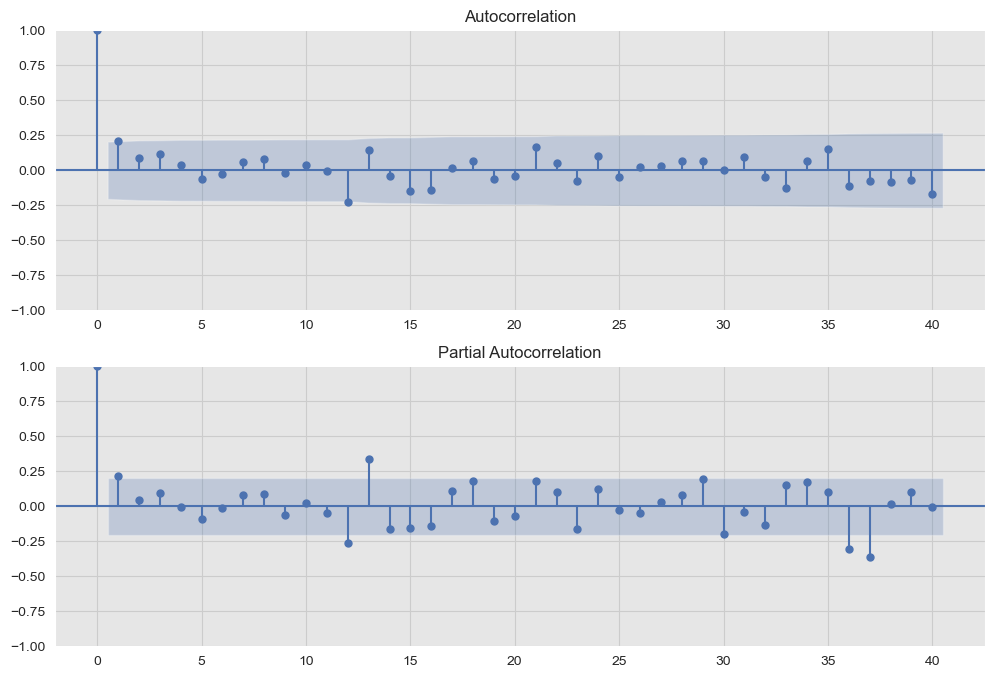

In [28]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(df['Seasonal First Difference'].iloc[13:],lags=40,ax=ax2)

- autocorrelation graph tells us the AR lag p = 1
- partial autocorrelation graph tells us the MA lag q = 1
- we consider first order seasonal difference d = 1

- first we show that ARIMA does not work as data is seasonal

In [29]:
from statsmodels.tsa.arima.model import ARIMA
model=ARIMA(df['Sales'],order=(1,1,1))
model_fit=model.fit()
model_fit.summary()

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Tue, 04 Apr 2023   AIC                           1911.627
Time:                        15:04:08   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.316      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Date'>

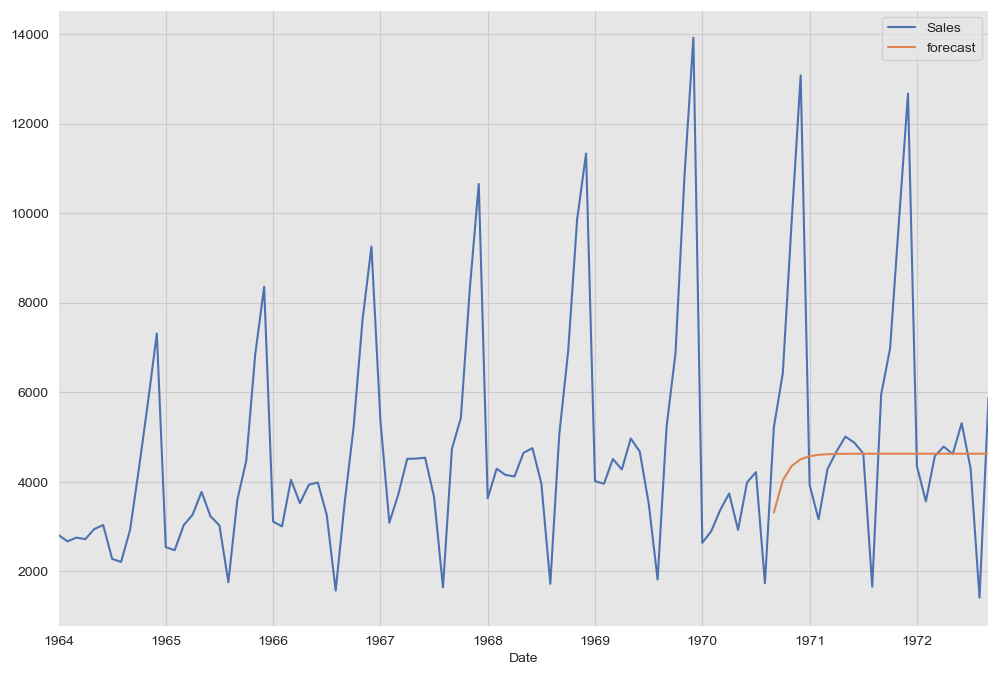

In [30]:
df['forecast']=model_fit.predict(start=80,end=105,dynamic=True)
df[['Sales','forecast']].plot(figsize=(12,8))

### next we use SARIMAX

In [31]:
n = 105
prop_train = 0.9
n_train = round(prop_train * n)
sarimax_train = df['Sales'][:n_train]
sarimax_test = df['Sales'][n_train:]

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(sarimax_train,order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()
results.summary()

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                   94
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -653.166
Date:                            Tue, 04 Apr 2023   AIC                           1316.331
Time:                                    15:04:09   BIC                           1328.303
Sample:                                01-01-1964   HQIC                          1321.135
                                     - 10-01-1971                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2996      0.089      3.351      0.001       0.124       0.475
ma.L1         -0.9470      0.049    -19.450      0.000      -1.042      -0.852
ar.S.L12      -0.6150      0.265     -2.322      0.020      -1.134      -0.096
ma.S.L12       0.3703      0.277      1.336      0.181      -0.173       0.913
sigma2      5.329e+05   6.97e+04      7.642      0.000    3.96e+05     6.7e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):                 5.17
Prob(Q):                              0.60   Prob(JB):                         0.08
Heteroskedasticity (H):               1.87   Skew:                            -0.21
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
std_sarimax = np.sqrt(np.sum(np.power(results.bse, 2)))
df['forecast'] = results.predict(start=n_train,end=n,dynamic=True)
df['std'] = std_sarimax
df['forecast_lwr'] = df['forecast'] - 2*df['std']
df['forecast_upr'] = df['forecast'] + 2*df['std']

In [34]:
temp = prod_df.copy()
temp = temp.reset_index()

[Text(0.5, 1.0, 'Kaggle Real Data'), Text(0.5, 0, 'Date'), Text(0, 0.5, '')]

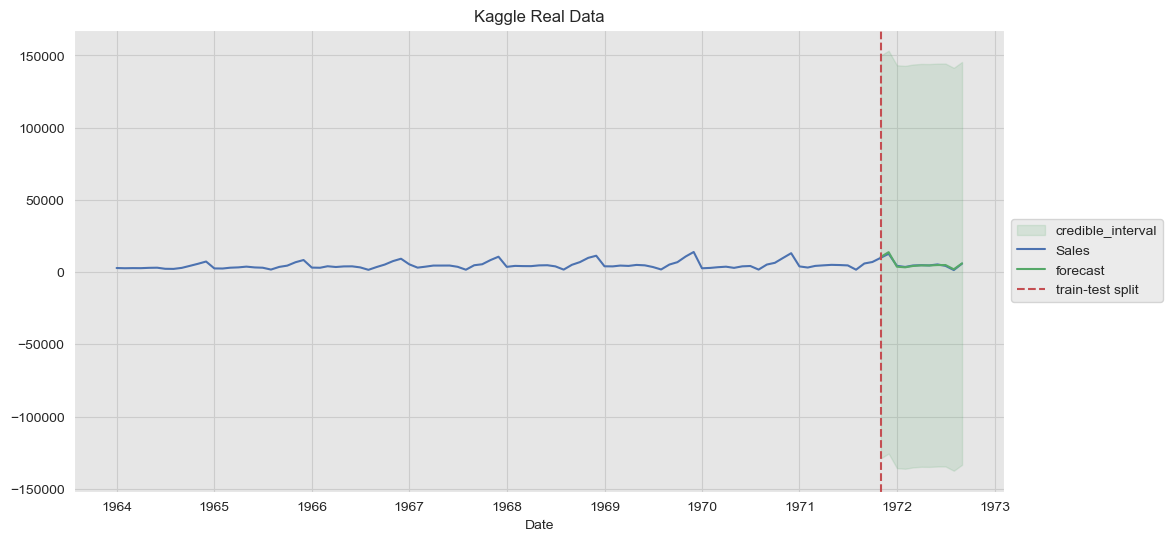

In [35]:
fig, ax = plt.subplots()

ax.fill_between(
    x=temp['Date'], 
    y1=df['forecast_lwr'], 
    y2=df['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='Date', y='Sales', data=df, color=sns_c[0], label = 'Sales', ax=ax)
sns.lineplot(x='Date', y='forecast', data=df, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(temp['Date'][n_train], color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Kaggle Real Data', xlabel='Date', ylabel='')

In [36]:
sarimax_pred = df['forecast'][n_train:].to_numpy().reshape((n-n_train,1))
sarimax_test = sarimax_test.to_numpy().reshape((sarimax_test.shape[0],1))

In [37]:
from sklearn.metrics import r2_score
sarimax_R2_score = r2_score(sarimax_test, sarimax_pred)
print(f'R2 Score Test = {sarimax_R2_score}')

R2 Score Test = 0.9678057595403864


In [38]:
from sklearn.metrics import mean_absolute_error
sarimax_MAE = mean_absolute_error(y_true=sarimax_test, y_pred=sarimax_pred)
print(f'MAE Test = {sarimax_MAE}')

MAE Test = 440.9971574251576


c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Sarimax Model - Errors'),
 Text(0.5, 0, 'error'),
 Text(0, 0.5, '')]

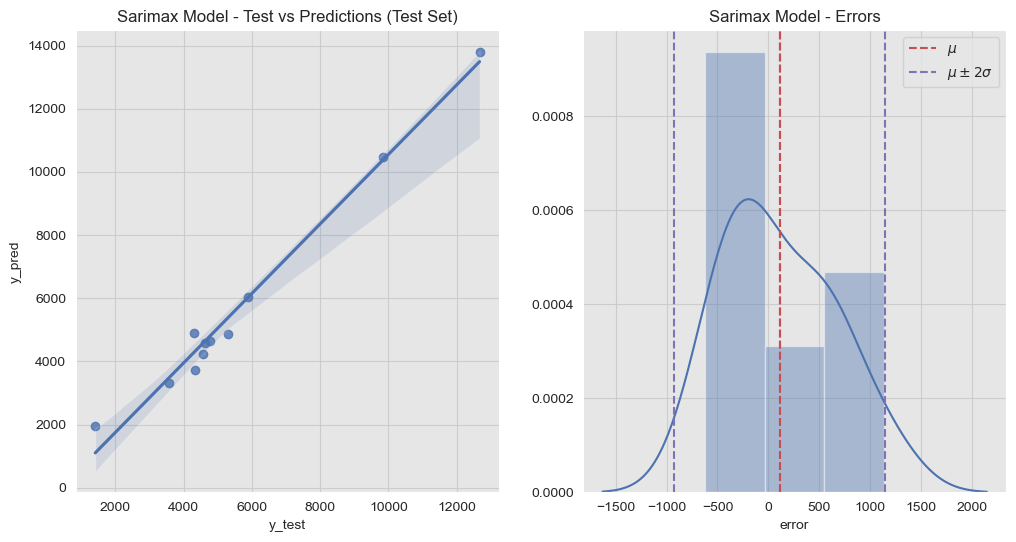

In [39]:
errors = sarimax_pred - sarimax_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=sarimax_test.flatten(), y=sarimax_pred.flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Sarimax Model - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred');
ax[1].set(title='Sarimax Model - Errors', xlabel='error', ylabel=None)

- future prediction

In [40]:
from pandas.tseries.offsets import DateOffset
future_dates=[df.index[-1]+ DateOffset(months=x)for x in range(0,60)]

In [41]:
future_datest_df=pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [42]:
future_datest_df.index.name = "Date"

In [43]:
future_datest_df.tail()

,Sales,Seasonal First Difference,forecast,std,forecast_lwr,forecast_upr
Date,,,,,,
1977-04-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-05-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-06-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-07-01,NaN,NaN,NaN,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN,NaN,NaN,NaN


In [44]:
new_df=pd.concat([df,future_datest_df])

In [45]:
std_sarimax = np.sqrt(np.sum(np.power(results.bse, 2)))
new_df['forecast'] = results.predict(start=n_train,end=new_df.shape[0],dynamic=True)
new_df['std'] = std_sarimax
new_df['forecast_lwr'] = new_df['forecast'] - 2*new_df['std']
new_df['forecast_upr'] = new_df['forecast'] + 2*new_df['std']

In [46]:
temp2 = new_df.copy()
temp2 = temp2.reset_index()

[Text(0.5, 1.0, 'Kaggle Real Data'), Text(0.5, 0, 'Date'), Text(0, 0.5, '')]

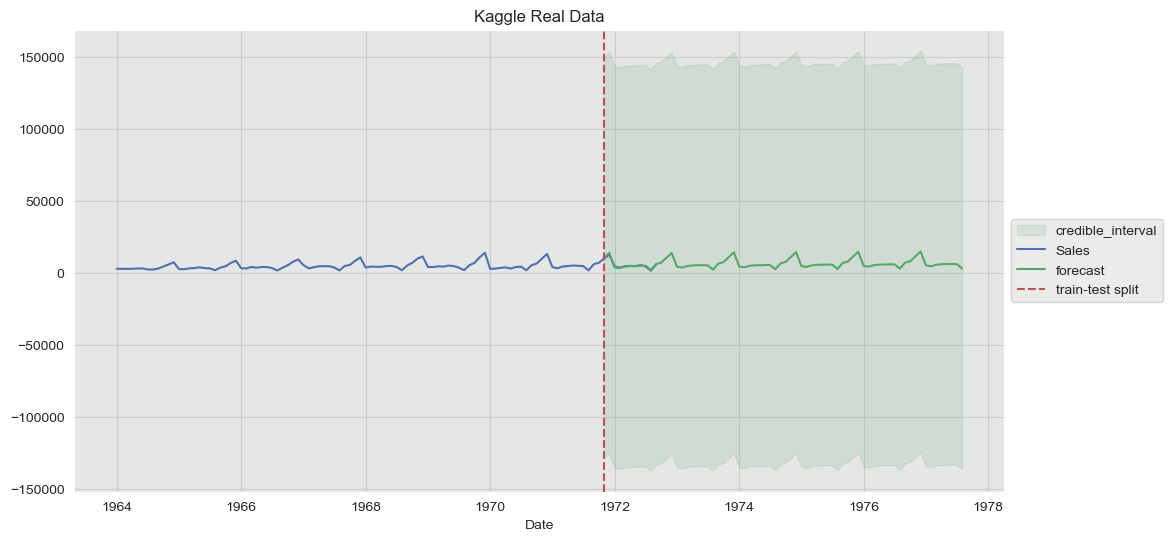

In [47]:
fig, ax = plt.subplots()

ax.fill_between(
    x=temp2['Date'], 
    y1=new_df['forecast_lwr'], 
    y2=new_df['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='Date', y='Sales', data=new_df, color=sns_c[0], label = 'Sales', ax=ax)
sns.lineplot(x='Date', y='forecast', data=new_df, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(temp2['Date'][n_train], color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Kaggle Real Data', xlabel='Date', ylabel='')

## Gaussian Processes for Time-Series Forecasting 
### (A non-parametric model)


### Deciding kernels for the components of the data is the main part

- This data has around 3 sesaonal components

In [63]:
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared, ConstantKernel

# To model noise, noise_level = sigma**2
k0 = WhiteKernel(noise_level=0.3**2, noise_level_bounds=(0.1**2, 0.5**2))

# To model periodic component, periodicity to be set as what is observed in data
k1 = ConstantKernel(constant_value=2) * \
  ExpSineSquared(length_scale=1.0, periodicity=12, periodicity_bounds=(8, 14))

# To model the trend component
k2 = ConstantKernel(constant_value=1e8, constant_value_bounds=(1e1, 1e10)) * \
  RBF(length_scale=1000.0, length_scale_bounds=(1e1, 1e4)) 

# To model the trend (non linear), its a scale mixture of RBF kernels
# k2 = ConstantKernel(constant_value=100, constant_value_bounds=(1, 500)) * \
#   RationalQuadratic(length_scale=500, length_scale_bounds=(1, 1e4), alpha= 50.0, alpha_bounds=(1, 1e3))

# To model another seasonal component
k3 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=10.0, periodicity=12, periodicity_bounds=(10, 15))

# To model another seasonal component
k4 = ConstantKernel(constant_value=1) * \
  ExpSineSquared(length_scale=100.0, periodicity=12, periodicity_bounds=(10, 15))

kernel_4  = k0 + k1 + k2 + k3 + k4

In [64]:
from sklearn.gaussian_process import GaussianProcessRegressor
# Define GaussianProcessRegressor object. 
gp4 = GaussianProcessRegressor(
    kernel=kernel_4, 
    n_restarts_optimizer=10, 
    normalize_y=True,
    alpha=0.0
)

In [65]:
gp_data = prod_df.reset_index()

In [67]:
gp_data['t'] = np.arange(gp_data.shape[0])

In [68]:
X = gp_data['t'].values.reshape(n, 1)

prop_train = 0.9
n_train = round(prop_train * n)

X_train = X[:n_train]
X_test = X[n_train:]

y = gp_data['Sales'].values.reshape(n ,1)
y_train = y[:n_train]
y_test = y[n_train:]

[Text(0.5, 1.0, 'GP4 Prior Samples'), Text(0.5, 0, 't')]

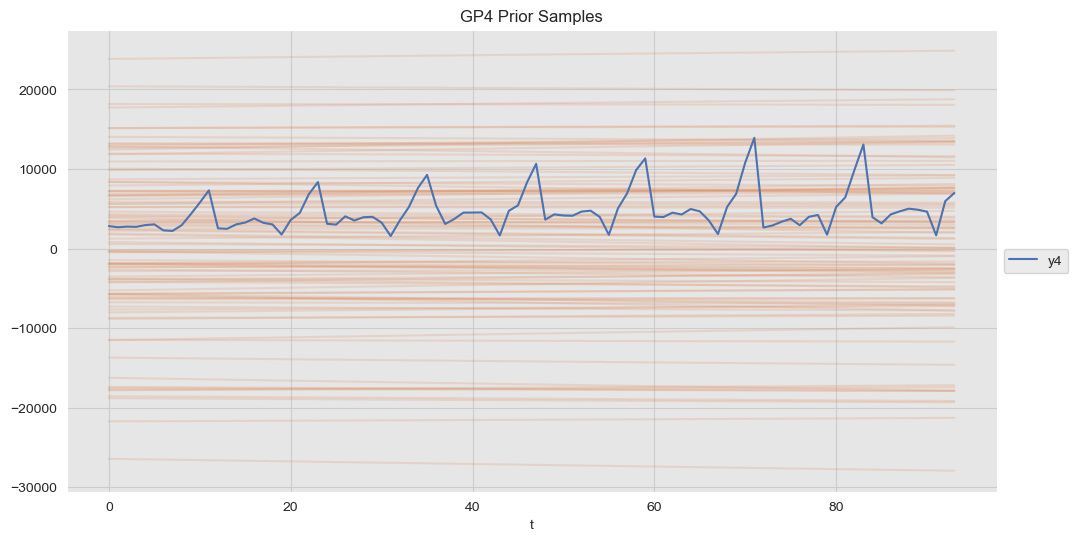

In [69]:
gp4_prior_samples = gp4.sample_y(X=X_train, n_samples=100)

fig, ax = plt.subplots()
for i in range(100):
    sns.lineplot(x=X_train[...,0], y = gp4_prior_samples[:, i], color=sns_c[1], alpha=0.2, ax=ax)
sns.lineplot(x=X_train[...,0], y=y_train[..., 0], color=sns_c[0], label='y4', ax=ax) 
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='GP4 Prior Samples', xlabel='t')

In [70]:
gp4.fit(X_train, y_train)

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k2__k1__constant_value is close to the specified lower bound 10.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.0,
                         kernel=WhiteKernel(noise_level=0.09) + 1.41**2 * ExpSineSquared(length_scale=1, periodicity=12) + 1e+04**2 * RBF(length_scale=1e+03) + 1**2 * ExpSineSquared(length_scale=10, periodicity=12) + 1**2 * ExpSineSquared(length_scale=100, periodicity=12),
                         n_restarts_optimizer=10, normalize_y=True)

In [71]:
k = 5*12 # 5 more cycles
t = n + np.arange(1,k)
future_df = pd.DataFrame({'Date': None, 'Sales': None, 't': t})


In [72]:
new_df = pd.concat([gp_data, future_df], ignore_index=True)

In [73]:
gp_test = new_df['t'].to_numpy().reshape((new_df['t'].shape[0],1))

In [74]:
y_pred, y_std = gp4.predict(gp_test, return_std=True)

new_df['forecast'] = y_pred
new_df['std'] = y_std
new_df['forecast_lwr'] = new_df['forecast'] - 2*new_df['std']
new_df['forecast_upr'] = new_df['forecast'] + 2*new_df['std']

[Text(0.5, 1.0, 'Kaggle Real Data'),
 Text(0.5, 0, 'Month Number'),
 Text(0, 0.5, '')]

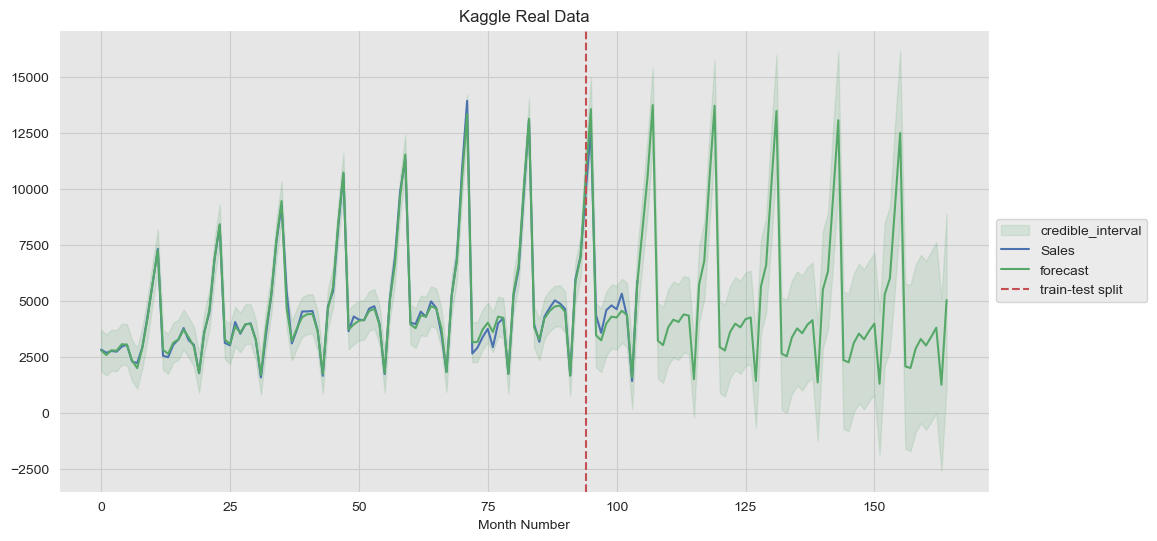

In [75]:
fig, ax = plt.subplots()

ax.fill_between(
    x=new_df['t'], 
    y1=new_df['forecast_lwr'], 
    y2=new_df['forecast_upr'], 
    color=sns_c[2], 
    alpha=0.15, 
    label='credible_interval'
)

sns.lineplot(x='t', y='Sales', data=new_df, color=sns_c[0], label = 'Sales', ax=ax)
sns.lineplot(x='t', y='forecast', data=new_df, color=sns_c[2], label='forecast', ax=ax)

ax.axvline(n_train, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Kaggle Real Data', xlabel='Month Number', ylabel='')

In [76]:
from sklearn.metrics import mean_absolute_error
# print(f'R2 Score Train = {gp3.score(X=X_train, y=y_train): 0.3f}')
print(f'GP R2 Score Test = {gp4.score(X=X_test, y=y_test): 0.3f}')
print(f'SARIMAX R2 Score Test = {sarimax_R2_score: 0.3f}')

# print(f'MAE Train = {mean_absolute_error(y_true=y_train, y_pred=gp3.predict(X_train)): 0.3f}')
print(f'GP MAE Test = {mean_absolute_error(y_true=y_test, y_pred=gp4.predict(X_test)): 0.3f}')
print(f'SARIMAX MAE Test = {sarimax_MAE: 0.3f}')

GP R2 Score Test =  0.964
SARIMAX R2 Score Test =  0.968
GP MAE Test =  487.360
SARIMAX MAE Test =  440.997


c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Sarimax Model - Errors'),
 Text(0.5, 0, 'error'),
 Text(0, 0.5, '')]

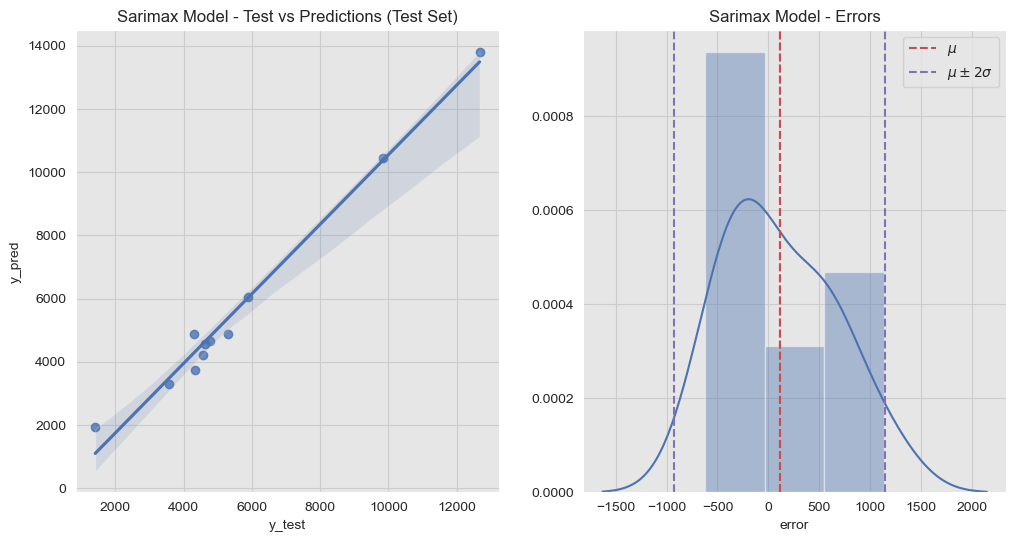

In [77]:
errors = sarimax_pred - sarimax_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=sarimax_test.flatten(), y=sarimax_pred.flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Sarimax Model - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred')
ax[1].set(title='Sarimax Model - Errors', xlabel='error', ylabel=None)

c:\Users\Abhinav\anaconda3\envs\timeSeries\Lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 1.0, 'Model 3  - Errors'), Text(0.5, 0, 'error'), Text(0, 0.5, '')]

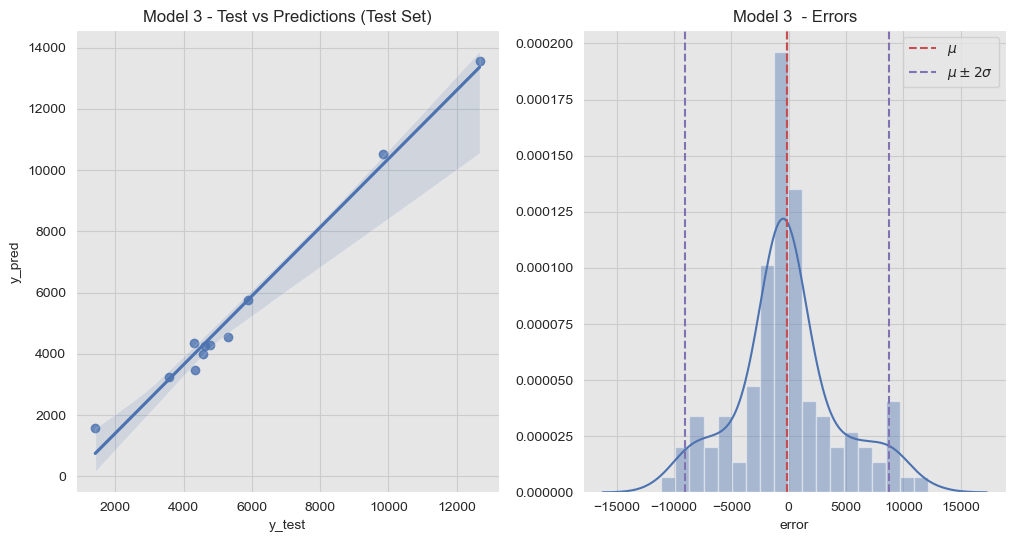

In [78]:
errors = gp4.predict(X_test) - y_test
errors = errors.flatten()
errors_mean = errors.mean()
errors_std = errors.std()

fig, ax = plt.subplots(1, 2, figsize=(12, 6)) 
sns.regplot(x=y_test.flatten(), y=gp4.predict(X_test).flatten(), ax=ax[0])
sns.distplot(a=errors, ax=ax[1])
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--', label=f'$\mu$')
ax[1].axvline(x=errors_mean + 2*errors_std, color=sns_c[4], linestyle='--', label=f'$\mu \pm 2\sigma$')
ax[1].axvline(x=errors_mean - 2*errors_std, color=sns_c[4], linestyle='--')
ax[1].axvline(x=errors_mean, color=sns_c[3], linestyle='--')
ax[1].legend()
ax[0].set(title='Model 3 - Test vs Predictions (Test Set)', xlabel='y_test', ylabel='y_pred')
ax[1].set(title='Model 3  - Errors', xlabel='error', ylabel=None)